<center><img src="car.jpg" width=500></center>


Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

Knowing all of this, On the Road car insurance have requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

## GOAL:
<ul>
    <li>Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the "outcome" column), excluding the "id" column.</li>
    <li>Store as a DataFrame called best_feature_df, containing columns named "best_feature" and "best_accuracy" with the name of the feature with the highest accuracy, and the respective accuracy score. </li>
</ul>

In [90]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit

### loading the dataset and preprocessing

In [91]:
df = pd.read_csv('car_insurance.csv')
df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [92]:
# encoding driving_experience
driving_map = {
    "0-9y": 0,
    "10-19y": 1,
    "20-29y": 2,
    "30y+":3
}

df['driving_experience'] = df['driving_experience'].map(driving_map)

# encoding education
edu_map = {
    "none": 0,
    "high school": 1,
    "university": 2,
}

df['education'] = df['education'].map(edu_map)

# encoding income
income_map = {
    "poverty": 0,
    "working class": 1,
    "middle class": 2,
    "upper class":3
}

df['income'] = df['income'].map(income_map)

# encoding vehicle year
vehicle_year_map = {
    "before 2015": 0,
    "after 2015": 1,
}

df['vehicle_year'] = df['vehicle_year'].map(vehicle_year_map)

# encoding vehicle type
vehicle_type_map = {
    "sedan": 0,
    "sports car": 1,
}

df['vehicle_type'] = df['vehicle_type'].map(vehicle_type_map)

# dataframe post labeling
df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0,1,3,0.629027,1.0,1,0.0,1.0,10238,12000.0,0,0,0,0,0.0
1,750365,0,1,0,0,0,0.357757,0.0,0,0.0,0.0,10238,16000.0,0,0,0,0,1.0
2,199901,0,0,0,1,1,0.493146,1.0,0,0.0,0.0,10238,11000.0,0,0,0,0,0.0
3,478866,0,1,0,2,1,0.206013,1.0,0,0.0,1.0,32765,11000.0,0,0,0,0,0.0
4,731664,1,1,1,0,1,0.388366,1.0,0,0.0,0.0,32765,12000.0,0,2,0,1,1.0


id                       0
age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis                     0
past_accidents           0
outcome                  0
dtype: int64


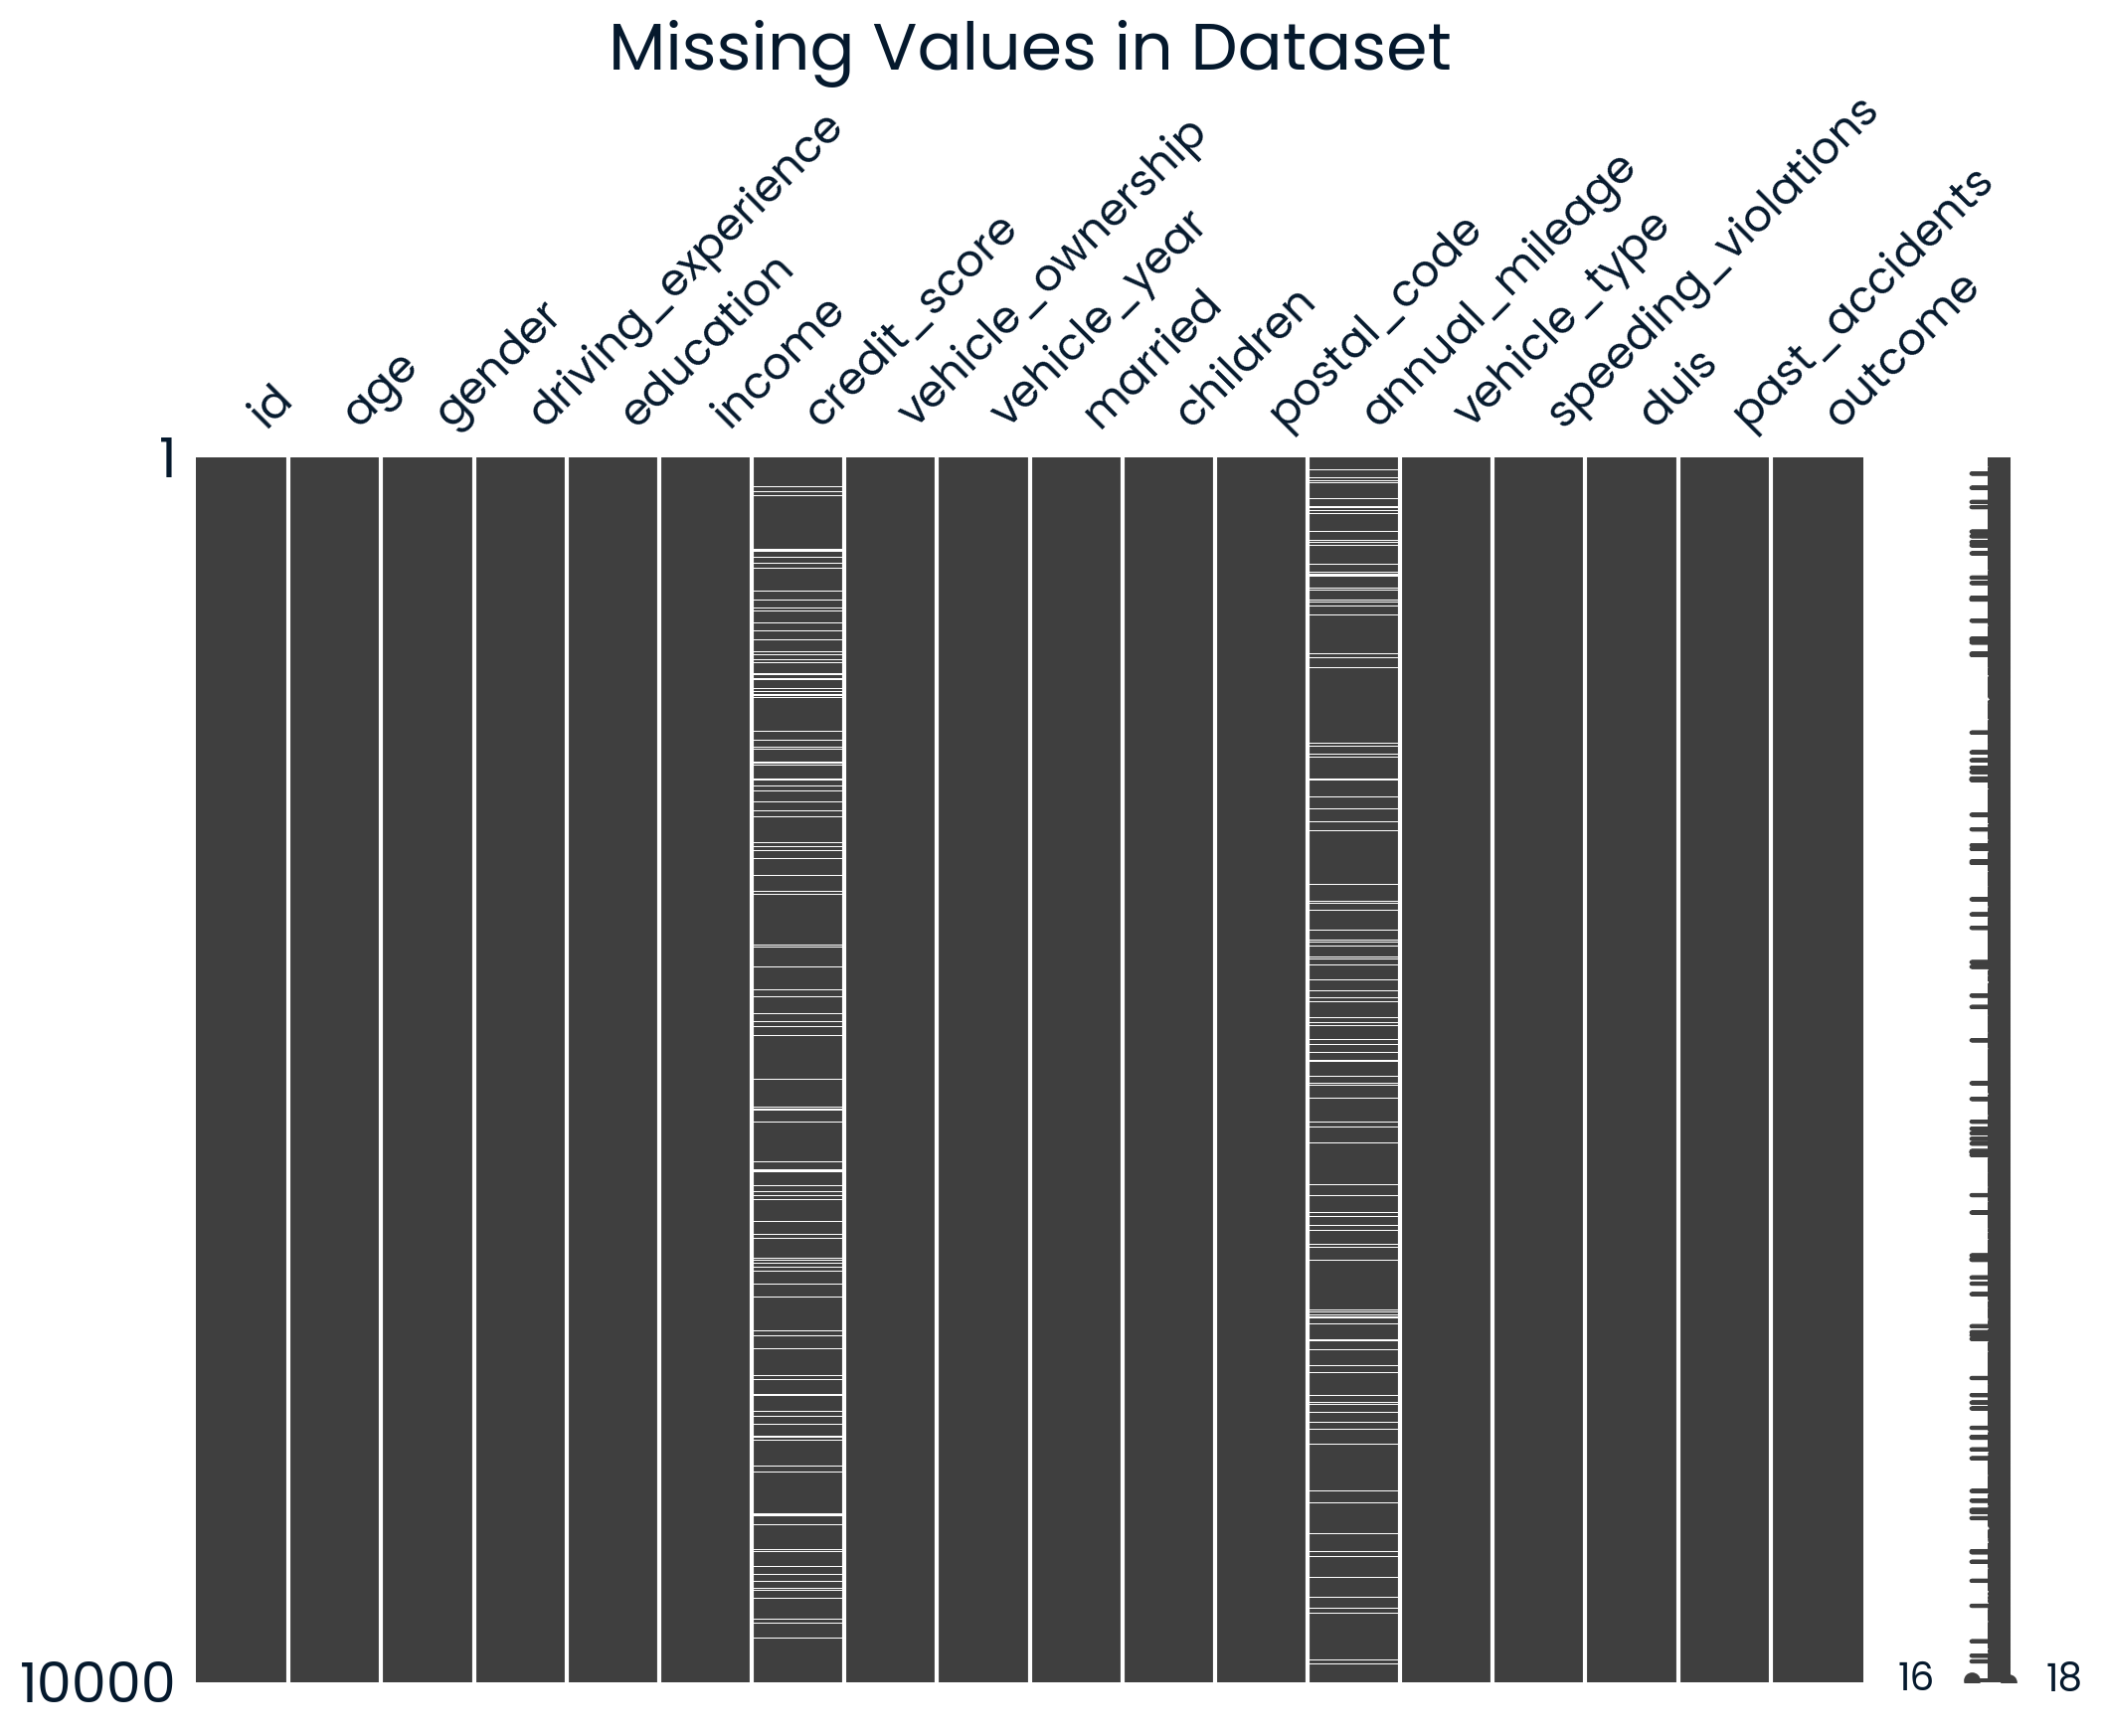

In [93]:
# checking for missing values
print(df.isnull().sum())
# visualize nan values
import missingno as mno
mno.matrix(df, figsize=(12,8))
plt.title('Missing Values in Dataset', fontsize=24)
plt.show()

The columns credit_score and annual_mileage have many missing values (~10% of all dataset). These missing values must be imputated (filled) to run a logit model.

The imputation can't be mean or median as the values depend heavily on each customer and vehicle type. The best approach will be imputation via regression.

### imputation via regression

In [94]:
# imputing credit_score

# making a copy of dataset to train regression model
df_reg = df.copy()
# dropping rows with nan values 
df_reg.dropna(inplace=True)

# training linear regression model on df_reg
from sklearn.linear_model import LinearRegression

# training the model for 'credit_score'
X_cr = df_reg.drop(columns=['credit_score'])
y_cr = df_reg['credit_score']
lr = LinearRegression()
lr.fit(X_cr, y_cr)


print("Model trained successfully.")

Model trained successfully.


In [95]:
def impute_with_regression(df, column, model, feature_columns):
    missing_indices = df[df[column].isnull()].index
    if not missing_indices.empty:
        X_missing = df.loc[missing_indices, feature_columns]
        valid_mask = X_missing.notnull().all(axis=1)
        valid_indices = missing_indices[valid_mask]
        if len(valid_indices) > 0:
            X_valid = df.loc[valid_indices, feature_columns]
            predicted_values = model.predict(X_valid)
            df.loc[valid_indices, column] = predicted_values
            return len(valid_indices)
        return 0
    return 0

# Use the same columns as used in model training
n = impute_with_regression(df, 'credit_score', lr, X_cr.columns)
print(f"Imputed {n} missing credit_score values using regression")

Imputed 894 missing credit_score values using regression


In [96]:
# imputing annual_mileage 

# making a copy of dataset to train regression model
df_reg = df.copy()
# dropping rows with nan values 
df_reg.dropna(inplace=True)

# training linear regression model on df_reg
from sklearn.linear_model import LinearRegression

# training the model for 'annual_mileage'
X_ann = df_reg.drop(columns=['annual_mileage'])
y_ann = df_reg['annual_mileage']
lr = LinearRegression()
lr.fit(X_ann, y_ann)

# imputing 
n = impute_with_regression(df, 'annual_mileage', lr, X_ann.columns)
print(f"Imputed {n} missing annual_mileage values using regression")

Imputed 869 missing annual_mileage values using regression


In [97]:
print(df['credit_score'].isnull().sum())
print(df['annual_mileage'].isnull().sum())

88
88


The columns still have 88 missing values. These are instances where both credit_score and annual_mileage. As these values are not even 1% of the dataset, they can be safely dropped.

In [98]:
df.dropna(inplace=True)
df.isnull().sum()

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
vehicle_type           0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
dtype: int64

### making logistic regression pipeline

In [99]:
# building pipeline for model training and evaluation
from sklearn.metrics import accuracy_score
# function to train and evaluate model
def train_evaluate_model(df,ind_var, dep_var='outcome'):
    formula = f"{dep_var} ~ {ind_var}"
    model = logit(formula, data=df).fit(disp=0)

    new_df = df[[f'{ind_var}', f'{dep_var}']]
    predicted_df = new_df.assign(predicted_outcome=model.predict(new_df).round())

    r2 = model.prsquared.round(3)
    aic = model.aic.round(3)
    bic = model.bic.round(3)
    accuracy = accuracy_score(predicted_df[f'{dep_var}'], predicted_df['predicted_outcome']).round(3)
    return r2, aic, bic, accuracy

In [100]:
columns = df.columns.tolist()
columns.pop()
columns.pop(0)

'id'

In [101]:
# Create an empty dictionary to store all results
model_results = {}

for col in columns:
    # Now it unpacks 4 values, matching the fixed function
    r2, aic, bic, accuracy = train_evaluate_model(df, col)
    
    # Store all 4 results in the dictionary, using the column name as the key
    model_results[col] = {
        'r2': r2,
        'aic': np.log(aic),
        'bic': np.log(bic),
        'accuracy': accuracy
    }


In [102]:
results = pd.DataFrame.from_dict(model_results, orient='index')
results

,r2,aic,bic,accuracy
age,0.177,9.225241,9.226659,0.775
gender,0.009,9.410205,9.411384,0.687
driving_experience,0.248,9.134201,9.135754,0.777
education,0.029,9.390262,9.391465,0.687
income,0.145,9.263172,9.264538,0.742
credit_score,0.092,9.322613,9.323900,0.711
vehicle_ownership,0.111,9.301414,9.302728,0.735
vehicle_year,0.079,9.337450,9.338718,0.687
married,0.056,9.361622,9.362859,0.687
children,0.042,9.376029,9.377248,0.687


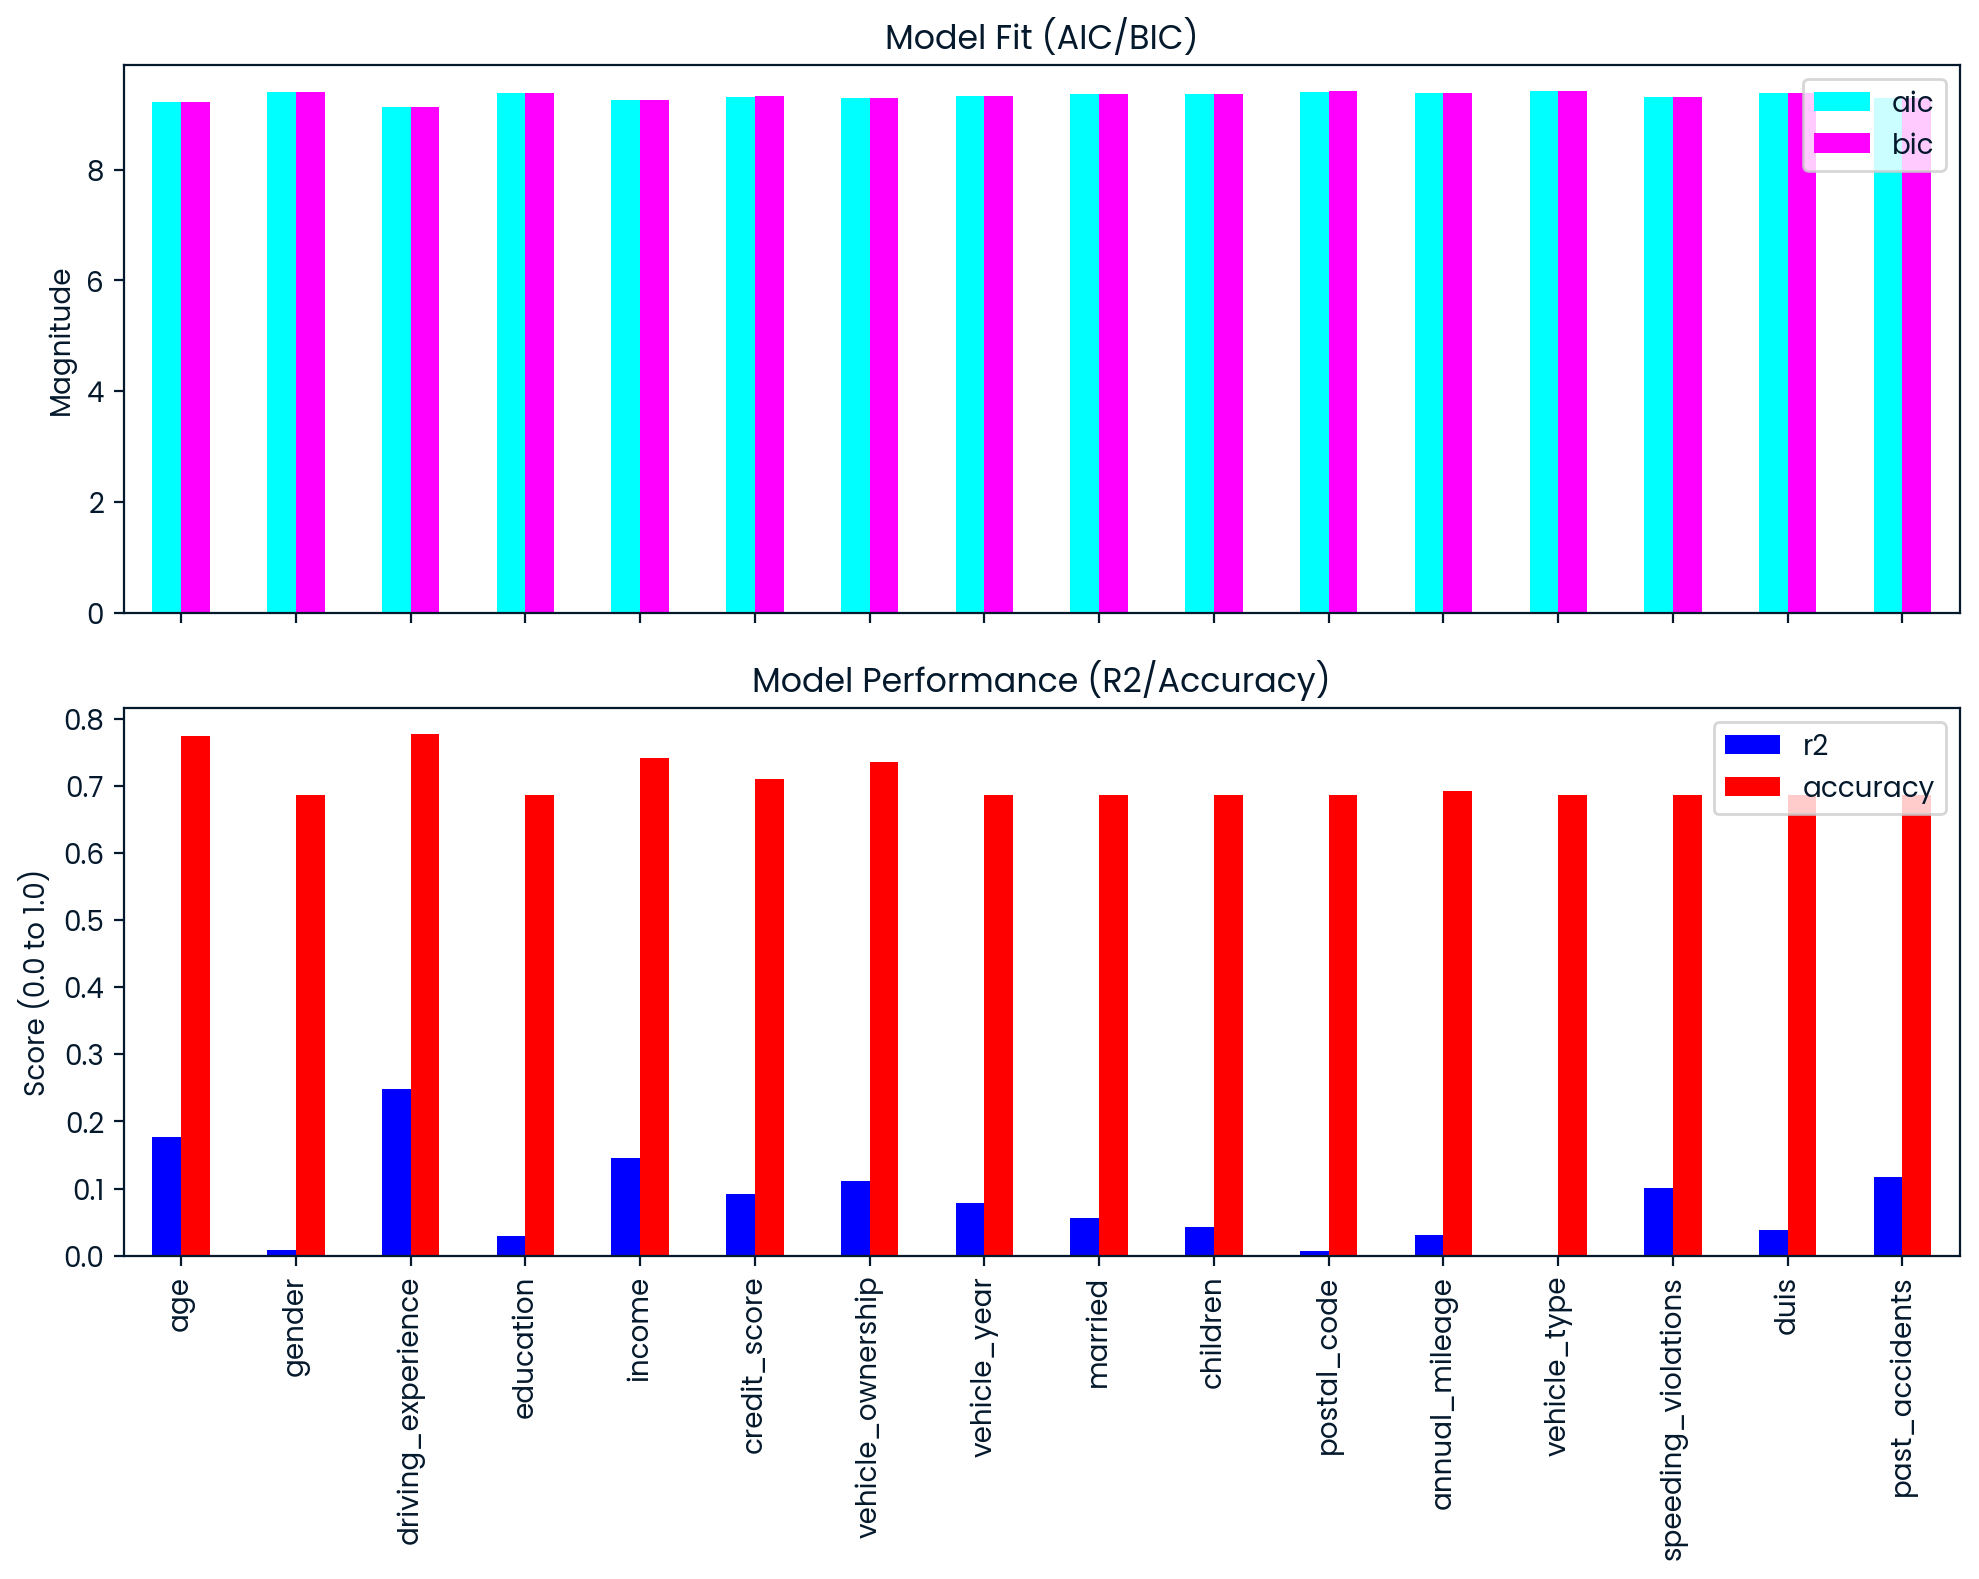

In [103]:
# Define which columns go where
small_cols = ['r2', 'accuracy']
large_cols = ['aic', 'bic']

# Create a figure with two subplots, sharing the x-axis
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Plot large values on the top axis (axes[0])
results[large_cols].plot(kind='bar', cmap='cool', ax=axes[0])
axes[0].set_title('Model Fit (AIC/BIC)')
axes[0].set_ylabel('Magnitude')

# Plot small values on the bottom axis (axes[1])
results[small_cols].plot(kind='bar', cmap='bwr', ax=axes[1])
axes[1].set_title('Model Performance (R2/Accuracy)')
axes[1].set_ylabel('Score (0.0 to 1.0)')

# Tidy up the plot
plt.tight_layout()
plt.show()

### finding the best feature

In [104]:
best_accuracy_index = results['accuracy'].idxmax()
print(best_accuracy_index)
best_accuracy_value = results['accuracy'].max()
print(best_accuracy_value)
best_aic_idx = results['aic'].idxmin()
best_bic_idx = results['bic'].idxmin()
print(best_aic_idx, best_bic_idx)

driving_experience
0.777
driving_experience driving_experience


'driving_experience' is the best feature as it has both the highest accuracy as well as the lowest AIC/BIC score.

In [105]:
best_feature_df = pd.DataFrame(
    {
        'best_feature':[best_accuracy_index],
        'best_accuracy':[best_accuracy_value]
    }
)
best_feature_df

,best_feature,best_accuracy
0,driving_experience,0.777
